In [1]:
import pandas as pd
import numpy as np
import re
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from Bresenheim import *
import pickle
from itertools import product
from scipy import ndimage
from numpy.linalg import norm
sns.set_style('darkgrid')
sns.set(font_scale = 1.4)

In [2]:
# load tracks : 
files = glob.glob('../data/real_cells/exp090814_cd4_movie1.txt')
filename = files[0]
df = pd.read_csv(files[0], sep="\t", names=['cell_id', 'time_id', 'time', 'x', 'y', 'z'])   
df['experiment'] = filename[19:28]
df['cell_type'] = filename[29:32]
df['movie'] = filename[38:39]

In [3]:
df.head()
# df[['x','y','z']]

,cell_id,time_id,time,x,y,z,experiment,cell_type,movie
0,1000000000,1,30,24.31300,294.679000,1.5,exp090814,cd4,1
1,1000000000,2,60,25.51002,295.263000,1.5,exp090814,cd4,1
2,1000000000,3,90,26.74300,294.526000,1.5,exp090814,cd4,1
3,1000000000,4,120,26.80600,294.520156,1.5,exp090814,cd4,1
4,1000000000,5,150,28.27700,293.858000,1.5,exp090814,cd4,1


In [4]:
df_list = [df[df.cell_id == i] for i in df.cell_id.unique()]

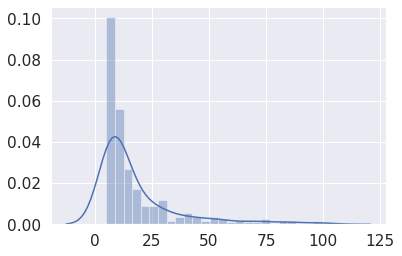

In [5]:
time_hist = [len(data.time.unique()) for data in df_list]
sns.distplot(time_hist)

In [6]:
len([t for t in time_hist if t > 80])

7

In [7]:
### extract tracks from all files
counter = 0
for f in files:
    print(f)
    df = pd.read_csv(f, sep="\t", names=['cell_id', 'time_id', 'time', 'x', 'y', 'z'])   
    df['experiment'] = f[19:28]
    df['cell_type'] = f[29:32]
    df['movie'] = f[38:39]
    #df = df[df.cell_type == 'cd8']
    df_list = [df[df.cell_id == i] for i in df.cell_id.unique()]
    for data in df_list:
        if len(data.time.unique()) > 0:
            track = data[['x','y','z']].to_numpy()
            name = '../data/real_cells/Mlab_track' + str(counter) + '.txt'
            np.savetxt(name,track)
            counter += 1

../data/real_cells/exp090814_cd4_movie1.txt


In [8]:
def auto_cor(cell_track): 
    averages = []
    for dt in range(0,60):
        # angles per dt: 
        cosines = []
        for i in range(len(cell_track) - 1 - dt):
            point1 = cell_track[i]
            point2 = cell_track[i + 1]
            point3 = cell_track[i + dt]
            point4 = cell_track[i + dt + 1]
            v1 = point2 - point1
            v2 = point4 - point3
            #cos = np.clip(np.dot(v1,v2)/(norm(v1) * norm(v2)),0,1)
            cos = np.dot(v1,v2)/(norm(v1) * norm(v2))
            #cos = abs(np.dot(v1,v2)/(norm(v1) * norm(v2)))
            cosines.append(cos)
        #if len(cosines) > 100: #minimum 100 mcs with actual displacement
        averages.append(np.average(cosines))
    return averages

In [9]:
track_files = glob.glob('../data/real_cells/Mlab_track*.txt')
autocorrelations = []
tracks = []
for f in track_files:
    track = np.loadtxt(f)
    AC = auto_cor(track)
    if np.nan not in AC:
        tracks.append(track)
        autocorrelations.append(AC)

/home/lau/anaconda2/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning:

Mean of empty slice.

/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [10]:
ac_df = pd.DataFrame(autocorrelations)
ac_df = ac_df.dropna()
ac_df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
12,1.0,0.271950,0.261794,0.319942,0.251463,0.298560,0.338682,0.167997,0.215433,0.175165,...,-0.229724,-0.076470,-0.061411,-0.083439,0.037160,-0.003944,-0.073153,-0.053313,0.071803,0.050597
47,1.0,-0.120962,-0.079768,0.012924,-0.023894,0.007419,-0.051494,-0.084355,-0.011520,0.071395,...,0.086912,0.058899,-0.010598,-0.118416,-0.068768,0.064679,0.157375,-0.076106,-0.213983,0.091517
73,1.0,-0.135100,0.028599,0.137967,-0.045644,0.001681,0.049044,0.031860,0.038269,0.065202,...,-0.132475,0.113496,0.099703,-0.049791,0.112241,0.132608,0.048652,0.049919,-0.017235,0.103595
74,1.0,-0.154266,0.072561,0.190791,0.036835,0.094687,0.056791,0.078102,0.046108,0.065226,...,-0.085192,0.062481,-0.079156,0.005611,-0.051523,0.031449,-0.093792,0.100470,0.104321,-0.063983
77,1.0,0.177217,0.325122,0.320726,0.206567,0.206924,0.249828,0.234290,0.202722,0.244356,...,-0.153666,0.022441,-0.140168,-0.143508,0.151262,-0.045866,-0.031958,0.005429,0.223487,-0.185158


<IPython.core.display.Javascript object>


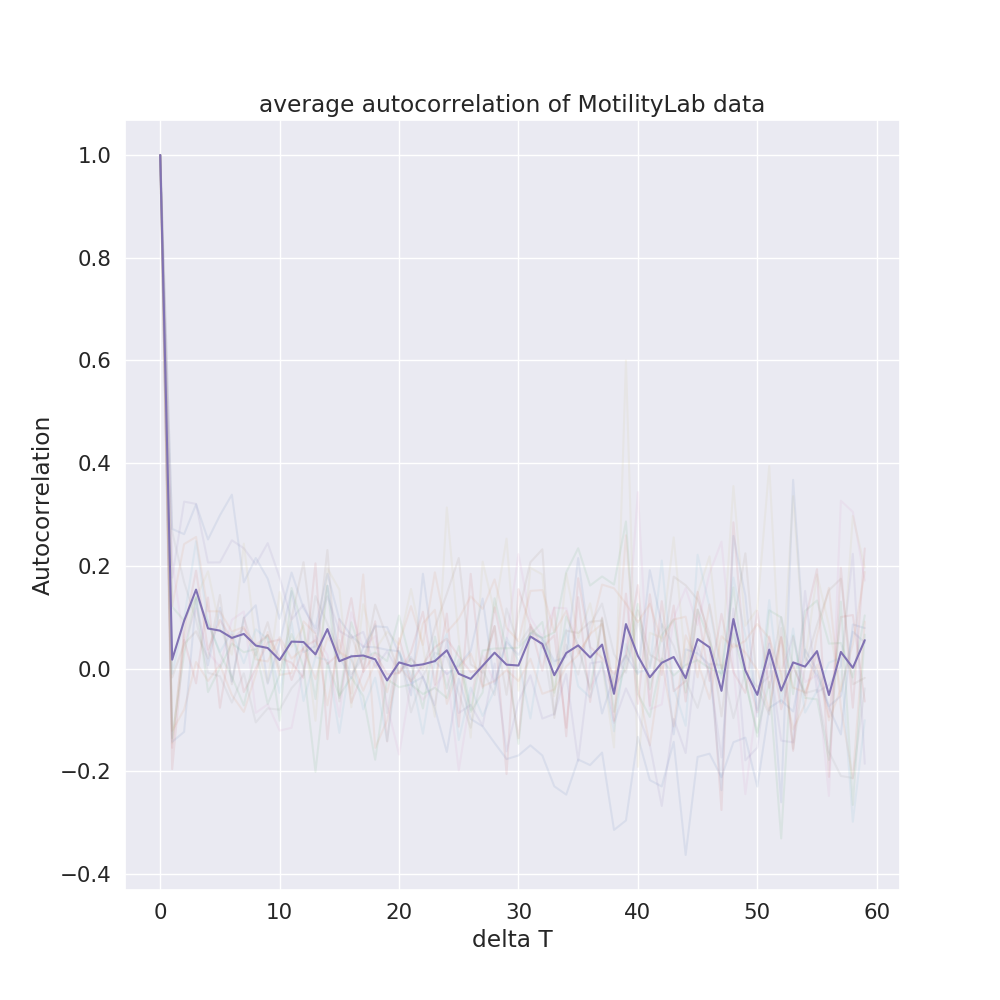

<function matplotlib.pyplot.show(*args, **kw)>

In [11]:
%matplotlib notebook
plt.figure(figsize = (10,10))
plt.plot(ac_df.T.to_numpy(),alpha = 0.1)
plt.plot(np.average(ac_df.T.to_numpy(),axis = 1))
plt.ylabel('Autocorrelation')
plt.xlabel('delta T')
plt.title('average autocorrelation of MotilityLab data')
plt.show

In [12]:
plt.scatter(np.average(ac_df.T.to_numpy(),axis = 1),)

TypeError: scatter() missing 1 required positional argument: 'y'

In [12]:
np.average(ac_df.T.to_numpy(),axis = 1)

array([ 1.        ,  0.10031201,  0.11694858,  0.10088594,  0.09353876,
        0.10364958,  0.0786249 ,  0.07531923,  0.0692447 ,  0.08027418,
        0.06514467,  0.0757019 ,  0.06075873,  0.0621481 ,  0.05334182,
        0.07084805,  0.06071889,  0.04944356,  0.06245216,  0.03439685,
        0.04964288,  0.04761711,  0.05970936,  0.07720375,  0.04920439,
        0.05549595,  0.04129347,  0.05022721,  0.04866795,  0.03877803,
        0.04997961,  0.05398569,  0.04645032,  0.03826213,  0.02501933,
        0.00788924,  0.02525615,  0.02265809,  0.04603852,  0.01779096,
        0.02304275,  0.02333503,  0.02585793,  0.01293669,  0.02680639,
       -0.00282841,  0.02949047,  0.00331463,  0.01614707,  0.01005627,
       -0.00102306,  0.03320814,  0.04237834,  0.02225835,  0.0113831 ,
        0.00834654,  0.01605464,  0.0125892 ,  0.01749813, -0.01413624])

<IPython.core.display.Javascript object>


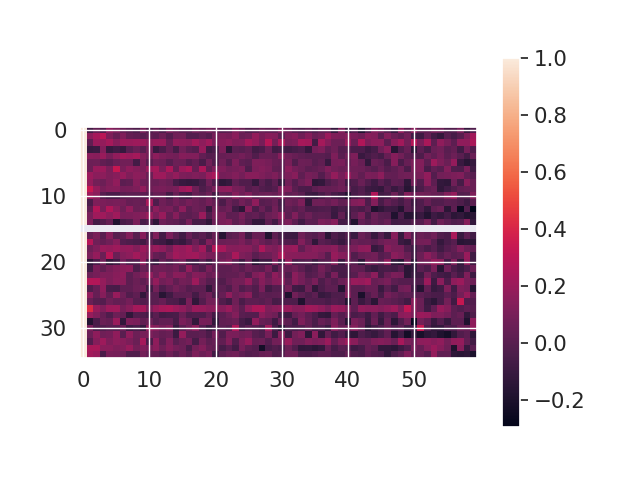

In [13]:
%matplotlib notebook
plt.imshow(autocorrelations)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


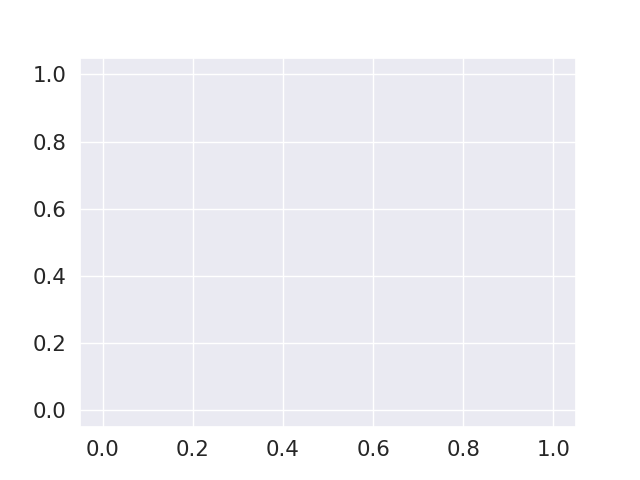

nan


In [14]:
%matplotlib notebook
#autocorrelations = np.array(autocorrelations).T
#print(autocorrelations[0,:])
##plt.plot(range(len(autocorrelations) - 1),autocorrelations)
#plt.plot(autocorrelations[1:],alpha = .2)
plt.plot(np.average(autocorrelations[1:]))
plt.show()
print(np.average(autocorrelations[1:]))
#print(len(tracks),len(autocorrelations))

In [15]:
from CPM_helpers1 import plot_celltrack
%matplotlib notebook

cell_track = tracks[68]

# plot path of center of mass  :
x = [c[0] for c in cell_track]
y = [c[1] for c in cell_track]
z = [c[2] for c in cell_track]

#fig = plt.figure()
ax = plt.axes(projection='3d')#projection='3d'
ax.plot3D(x,y,z)
ax.scatter3D(x[0],y[0],z[0],label = 'start')
ax.scatter3D(x[-1],y[-1],z[-1],label = 'end')
ax.legend()
plt.show()

IndexError: list index out of range

In [16]:
import networkx as nx 



<IPython.core.display.Javascript object>


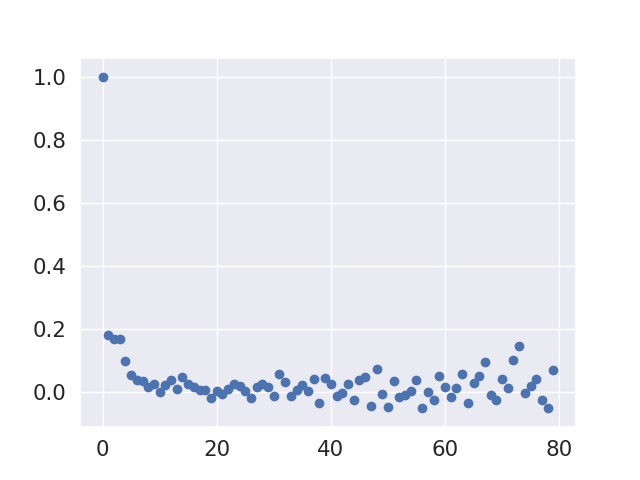

In [47]:
%matplotlib notebook
# load tracks : 
filename = "./exp090814_cd4_movie1.txt"
df = pd.read_csv(files[0], sep="\t", names=['cell_id', 'time_id', 'time', 'x', 'y', 'z'])   
df['experiment'] = filename[2:11] 
df['cell_type'] = filename[12:15]
df['movie'] = filename[21:22]

def auto_cor(cell_track, dots_for_dts, dts): 
    for dt in range(0,dts):
        dots = []
        for i in range(len(cell_track) - 1 - dt):
            point1 = cell_track[i]
            point2 = cell_track[i + 1]
            point3 = cell_track[i + dt]
            point4 = cell_track[i + dt + 1]
            v1 = point2 - point1
            v2 = point4 - point3
            dot = np.dot(v1,v2)/(norm(v1) * norm(v2))
            dots.append(dot)
        dots_for_dts[dt].extend(dots)

dts = 80
dots_for_dts = [[] for i in range(dts)]

for cell_id in df.cell_id.unique():
    celldf = df[df.cell_id == cell_id]
    track = celldf[['x','y','z']].to_numpy()
    auto_cor(track, dots_for_dts, dts)
    
averages = [np.mean(i) for i in dots_for_dts]

plt.scatter(range(dts), averages)
plt.show()